# Tohoku tsunami inversion

This series of notebooks is concerned with performing source inversion for the initial surface due to the earthquake which triggered the 2011 Tohoku tsunami.

We will use gradient-based optimisation to construct an initial free surface for which the resulting wave propagation is a "best fit" for GPS and pressure gauge data, in some sense.
We have data from two pressure gauges and five GPS gauges available, each of which is in the near field.

## 1. Comparison of gradients from continuous and discrete approaches

In order to construct the gradient required for the PDE constrained optimisation, we can make use of either the continuous or discrete form of the adjoint equations.
This first notebook compares the two approaches and checks the validity of the resulting gradients.
In addition, it checks that we are able to represent the timeseries mismatch quantity of interest in a form which is understandable by a finite element code.

In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [4]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import SolveVarFormBlock, NonlinearVariationalSolveBlock

In [5]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.misc import gaussian, ellipse

_[Define misc plotting functions]_

In [6]:
def plot_mesh(mesh2d, figure=None, axes=None):
    if axes is None:
        figure, axes = plt.subplots(figsize=(6, 6))
    triplot(mesh2d, axes=axes);
    axes.axis(False);
    axes.legend(loc='upper left');
    axes.set_title("Mesh ({:d} elements)".format(mesh2d.num_cells()))
    return axes

In [7]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [8]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        try:
            plot_field(field, fig, axes[i])
        except AttributeError:
            plot_mesh(field, fig, axes[i])
    return axes

### Forward model

Consider the shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0.
$$

For this simple implementation we use Taylor-Hood and Crank-Nicolson for for spatial and temporal discretisations, respectively.

In [9]:
level = 0
op = TohokuOptions(level=level)
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1

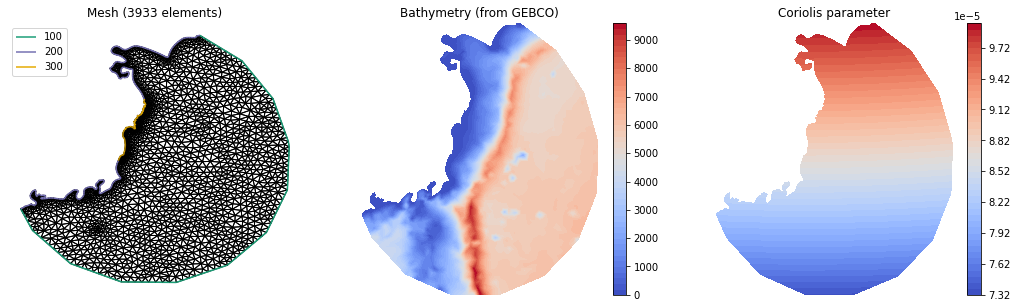

In [10]:
b = Function(P1, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))
plot_fields(mesh, b, f);

In this case we choose $\Gamma_{\mathrm{freeslip}}=\partial\Omega$ and $\Gamma_D=\Gamma_{100}$.

In [11]:
boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

In [12]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)

q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

n = FacetNormal(mesh)

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    for tag in boundary_conditions:
        if "freeslip" not in boundary_conditions[tag]:
            F += inner(zeta*n, b*uv)*ds(tag)
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()
eta.dat.name = "Final surface"

bcs = []
for tag in boundary_conditions:
    if "dirichlet" in boundary_conditions[tag]:
        bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bcs)
solver = LinearVariationalSolver(problem, solver_parameters=params)

Assume zero initial velocity and expand the initial surface over a radial basis:

$$
    \mathbf u|_{t=0}\equiv\boldsymbol0,\qquad
    \eta|_{t=0}=\sum_{k=1}^N m_kg_k,
$$

where $m_k$ are (constant in space) control parameters and $g_k$ are Gaussians.

For this experiment, we consider the simplest case where $N=1$, i.e. we represent the initial condition using just one radial basis function.
Following the inversion approach in __[Saito et al. 2011]__ we consider basis functions which are aligned with the fault line of the Tohoku earthquake and which are skewed in that direction.

Note that the following analysis is not restricted to Gaussian basis functions and would work for any basis.
In particular, we could use the bases for some finite element space, such as $\mathbb P1$.

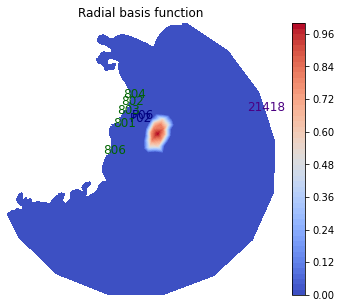

In [13]:
R = FunctionSpace(mesh, "R", 0)
m = Function(R).assign(10.0)

basis_function = Function(TaylorHood)
psi, phi = basis_function.split()

loc = (0.7e+06, 4.2e+06)
radii = (48e+03, 96e+03)
angle = pi/12
phi.interpolate(gaussian([loc + radii, ], mesh, rotation=angle))
phi.dat.name = "Radial basis function"

q_.project(m*basis_function);

axes = plot_field(phi);
op.annotate_plot(axes, gauges=True)

### Quantity of Interest

Suppose (for now) that we have observations of $\eta(t)|_g$ at a finite collection of gauges $g\in\mathcal G$ _for all time_.
Then the fit of the simulated free surface to the data may be quantified using the quantity of interest (QoI)

$$
J(\mathbf u,\eta)=\frac12\sum_{g\in\mathcal G}\int_0^T\big(\:\eta(\mathbf x_g,t)-\eta_g(t)\:\big)^2\;\mathrm dt.
$$

Because we are using FEM, we need to stay in $\mathcal H^1(\Omega)$ and therefore use the continuous formulation

$$
J(\mathbf u,\eta)=\frac12\sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb1_g\big(\:\eta(x,t)-\eta_g(t)\:\big)^2\;\mathrm dx\;\mathrm dt,
$$

where $\mathbb1_g$ is an indicator function related to a sufficiently small neighbourhood of gauge $g$.
(Note that the local mesh element size will limit how small this neighbourhood can be in practice.)

Clearly

$$
\frac{\partial J}{\partial\mathbf u}\equiv\boldsymbol0,\qquad
\frac{\partial J}{\partial\eta}=\sum_{g\in\mathcal G}\mathbb 1_g(\eta(\mathbf x,t)-\eta_g(t)).
$$

That is, the RHS of the adjoint equation depends on both the forward (free surface) solution and also the gauge timeseries.

Our aim is to optimise the control parameters $\{m_k\}_{k=1}^N$ in order to minimise $J(\mathbf u,\eta)$.
That is, we seek the representation of the initial surface for which running the forward model captures the gauge timeseries with minimal square error.

In practice, we don't actually have observations _for all time_ but only at particular instances.
Given a finite set of time levels $\mathcal T\subset(0,T]$ used by the time integration scheme, we can interpolate the observations between timesteps.

In [14]:
def sampled_timeseries(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t, d, running = [], [], []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        for i in range(num_lines):
            time, dat = f.readline().split()
            time, dat = float(time), float(dat)
            if np.isnan(dat):
                continue
            running.append(dat)
            if i % sample == 0 and i > 0:
                t.append(0.5*(time + time_prev))
                d.append(np.mean(running))
                running = 0
                time_prev = time
                running = []
                
    interp = scipy.interpolate.interp1d(t, d, bounds_error=False, fill_value='extrapolate')
    init = interp(0.0)
    
    def shifted(tau):
        return interp(tau) - init
    
    return shifted

Under the time discretisation the QoI becomes

$$
J(\mathbf u,\eta)=\frac12\sum_{t\in\mathcal T}w_t\sum_{g\in\mathcal G}\int_\Omega\mathbb1_g\big(\:\eta(x,t)-\eta_g(t)\:\big)^2\;\mathrm dx,
$$

where $\{w_t\}_{t\in\mathcal T}$ are appropriately chosen quadrature weights.
For Crank-Nicolson, the corresponding quadrature routine is the trapezium rule.

In order to assemble this QoI we need to (a) define the indicator functions and (b) create interpolants for the timeseries data.

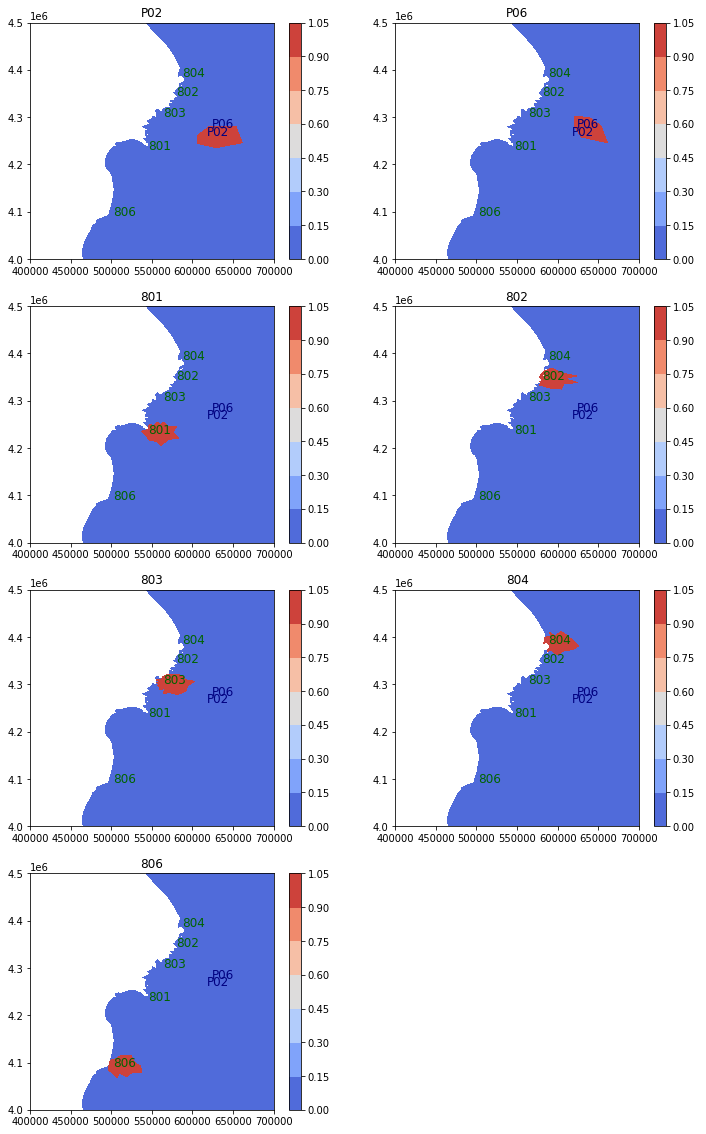

In [15]:
op.gauges.pop('21418')  # This pressure gauge isn't within the domain
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,), ], mesh), P0)
    
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12, 20))
for i, gauge in enumerate(gauges):
    ax = axes[i//2, i%2]
    fig.colorbar(tricontourf(op.gauges[gauge]['indicator'], axes=ax, cmap='coolwarm'), ax=ax);
    ax.set_xlim([0.4e+06, 0.7e+06]);
    ax.set_ylim([4.0e+06, 4.5e+06]);
    ax.set_title(gauge)
    op.annotate_plot(ax, coords='utm', gauges=True)
axes[3, 1].axis(False);

Note that these regions are both rather large and not really circular.
As the mesh is refined, we can improve the indicator on at least one of these accounts.

_[See following notebooks]_

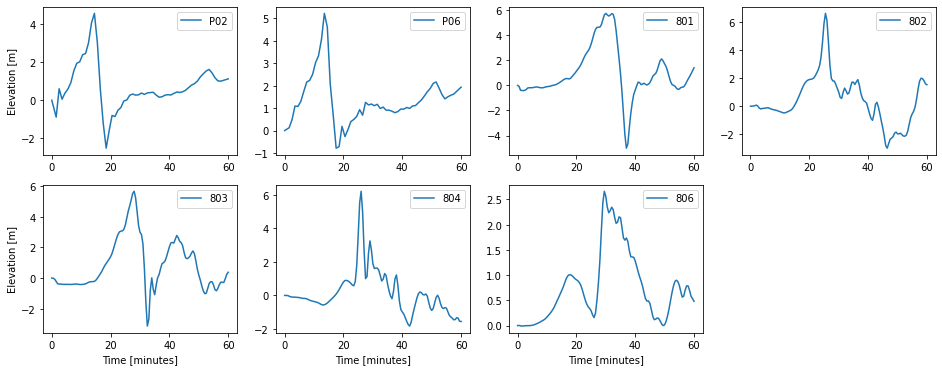

In [19]:
for gauge in gauges:
    op.gauges[gauge]['interpolator'] = sampled_timeseries(gauge, sample=60 if gauge[0] == 'P' else 1)

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 6))

t = np.linspace(0, 60*60, 24*5+1)
for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    ax.plot(t/60, op.gauges[gauge]['interpolator'](t), label=gauge)
    ax.legend()
    if i//4 > 0:
        ax.set_xlabel("Time [minutes]")
    if i%4 == 0:
        ax.set_ylabel("Elevation [m]")
axes[1, 3].axis('off');

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

In [16]:
# op.end_time = 3600.0
op.end_time = 1440.0  # TODO: TEMPORARY
for gauge in gauges:
    op.gauges[gauge]['timeseries'] = []
    op.gauges[gauge]['diff'] = []
    op.gauges[gauge]['timeseries_smooth'] = []
    op.gauges[gauge]['diff_smooth'] = []
    op.gauges[gauge]['data'] = []
    op.gauges[gauge]['init'] = None
    op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx, annotate=False)
times = []

t = 0.0
iteration = 0
J = 0
weight = Constant(1.0)
eta_obs = Constant(0.0)
while t < op.end_time:
    times.append(t)
    if iteration % 48 == 0:
        print("t = {:.1f} minutes".format(t/60))
    
    # Solve forward equation at current timestep
    solver.solve()
    
    # Time integrate QoI
    weight.assign(0.5 if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt else 1.0)
    u, eta = q.split()
    for gauge in op.gauges:
        
        # Point evaluation at gauges
        eta_discrete = eta.at(op.gauges[gauge]["coords"])
        if op.gauges[gauge]['init'] is None:
            op.gauges[gauge]['init'] = eta_discrete
        eta_discrete -= op.gauges[gauge]['init']
        op.gauges[gauge]['timeseries'].append(eta_discrete)
        
        # Interpolate observations
        obs = float(op.gauges[gauge]['interpolator'](t))
        eta_obs.assign(obs)
        op.gauges[gauge]['data'].append(obs)
        
        # Discrete form of error
        diff = 0.5*(eta_discrete - eta_obs.dat.data[0])**2
        op.gauges[gauge]['diff'].append(diff)

        # Continuous form of error
        I = op.gauges[gauge]['indicator']
        A = op.gauges[gauge]['area']
        diff = 0.5*I*(eta - eta_obs)**2
        J += assemble(weight*dtc*diff*dx)
        op.gauges[gauge]['diff_smooth'].append(assemble(diff*dx, annotate=False)/A)
        op.gauges[gauge]['timeseries_smooth'].append(assemble(I*eta_obs*dx, annotate=False)/A)
    
    # Increment
    q_.assign(q)
    t += op.dt
    iteration += 1
    
assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
print("t = {:.1f} minutes".format(t/60))
print("Quantity of interest = {:.4e}".format(J))

t = 0.0 minutes
t = 4.0 minutes
t = 8.0 minutes
t = 12.0 minutes
t = 16.0 minutes
t = 20.0 minutes
t = 24.0 minutes
Quantity of interest = 1.4969e+13


Having run the forward model, we can compare the initial and final solution, as well as the discrete and continuous versions of the timeseries.

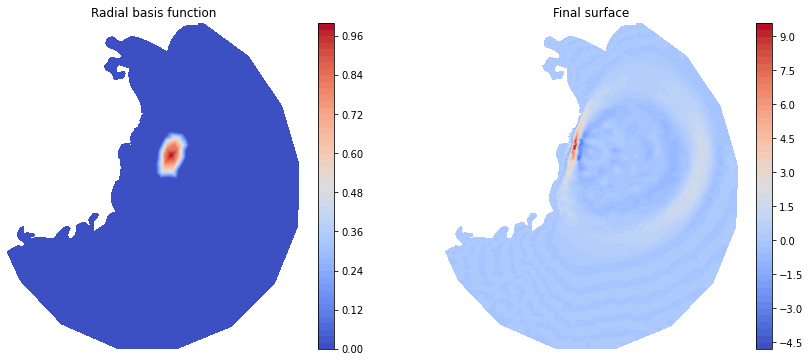

In [17]:
plot_fields(phi, eta, height=6);

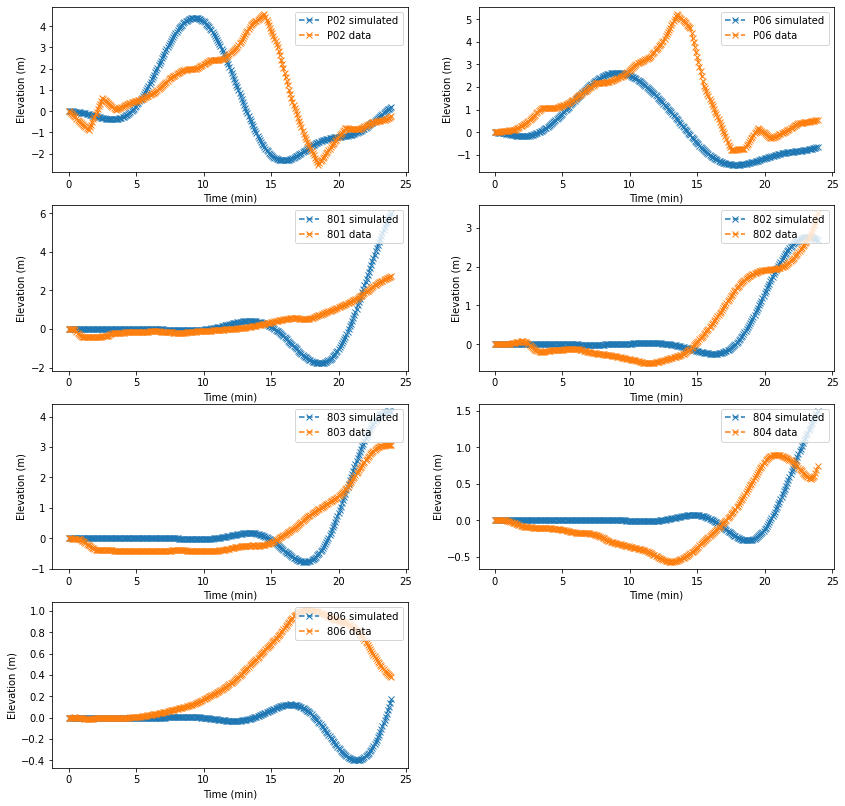

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 2*len(gauges)))

times = np.array(times)
for i, gauge in enumerate(gauges):
    ax = axes[i//2, i%2]
    ax.plot(times/60, op.gauges[gauge]['timeseries'], '--x', label=gauge + ' simulated')
    ax.plot(times/60, op.gauges[gauge]['data'], '--x', label=gauge + ' data')
    ax.legend(loc='upper right')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Elevation (m)')
axes[3, 1].axis('off');

Clearly the solution is far from accurate with this very simple initial condition.

Let's compare the continuous and discrete forms of the timeseries error to check that the former provides a good approximation to the latter.

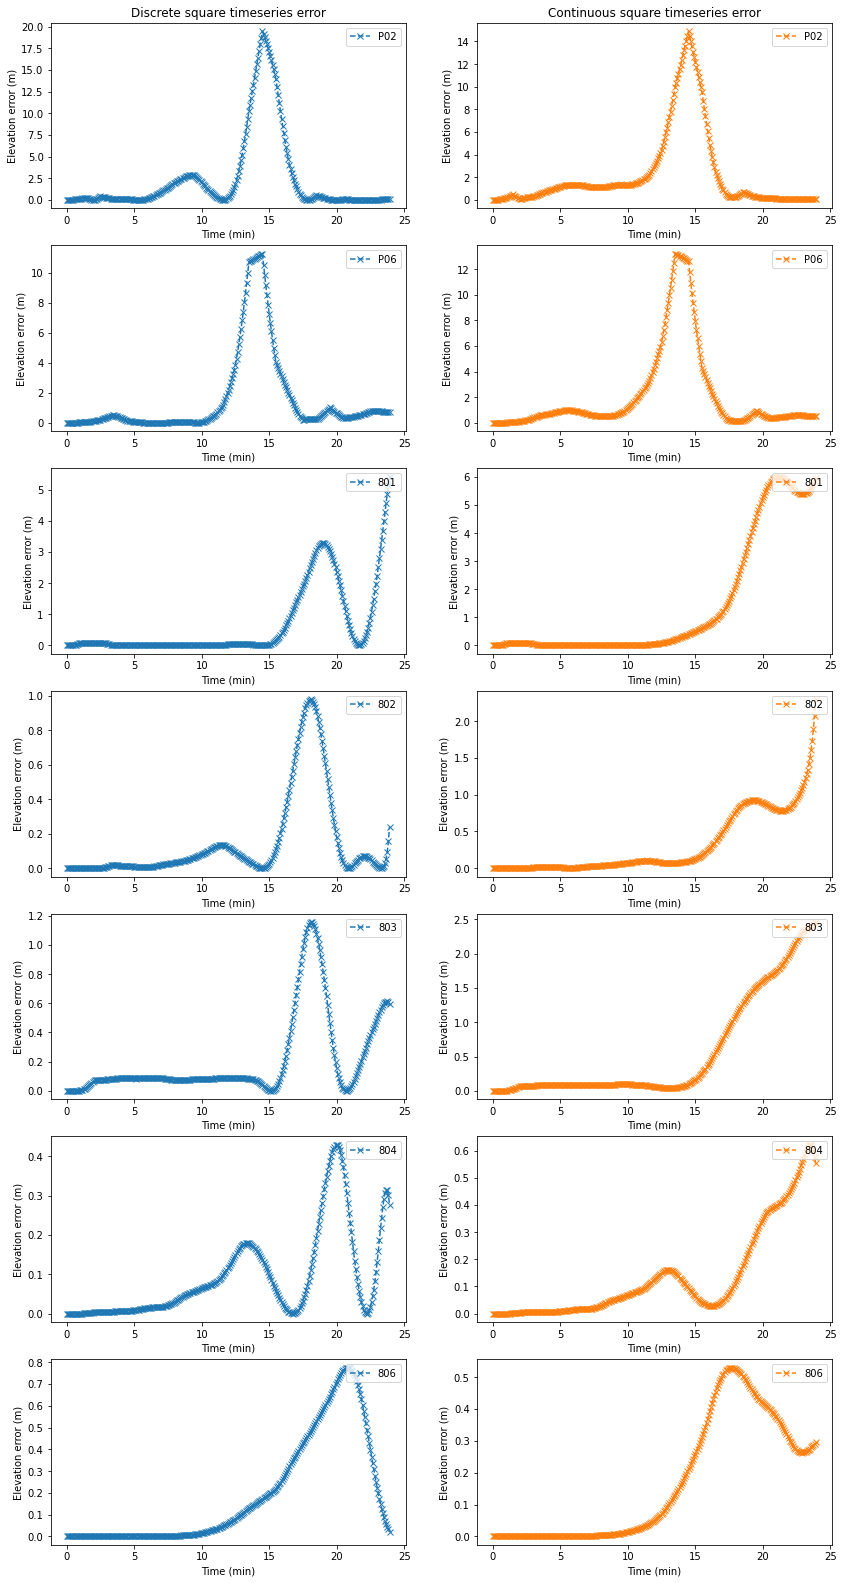

In [19]:
n = len(gauges)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 4*n))

axes[0, 0].set_title("Discrete square timeseries error")
axes[0, 1].set_title("Continuous square timeseries error")
for i, gauge in enumerate(gauges):
    
    N = len(op.gauges[gauge]['diff'])
    axes[i, 0].plot(times/60, op.gauges[gauge]['diff'], '--x', label=gauge)
    axes[i, 0].legend(loc='upper right')
    axes[i, 0].set_xlabel('Time (min)')
    axes[i, 0].set_ylabel('Elevation error (m)')
    
    N = len(op.gauges[gauge]['diff_smooth'])
    axes[i, 1].plot(times/60, op.gauges[gauge]['diff_smooth'], '--x', color='tab:orange', label=gauge)
    axes[i, 1].legend(loc='upper right')
    axes[i, 1].set_xlabel('Time (min)')
    axes[i, 1].set_ylabel('Elevation error (m)')

It seems that on this mesh the continuous form matches error signals in the discrete form for P02 and P06 and 806, but misses notable error spikes for 801-804. Using a finer mesh would probably help in this regard.

_[See the sequel of this notebook]_

We can also compare the total variation for each form:

In [31]:
msg = "total variation for gauge {:s}: continuous {:.4e}  discrete {:.4e}"
for gauge in gauges:
    tv_cts = total_variation(op.gauges[gauge]['diff_smooth'])
    tv_dis = total_variation(op.gauges[gauge]['diff'])
    print(msg.format(gauge, tv_cts, tv_dis))

total variation for gauge P02: continuous 3.2098e+01  discrete 4.7441e+01
total variation for gauge P06: continuous 2.8979e+01  discrete 2.5481e+01
total variation for gauge 801: continuous 7.3854e+00  discrete 1.2290e+01
total variation for gauge 802: continuous 2.6839e+00  discrete 2.6409e+00
total variation for gauge 803: continuous 2.5867e+00  discrete 3.1550e+00
total variation for gauge 804: continuous 9.5363e-01  discrete 1.5721e+00
total variation for gauge 806: continuous 8.2841e-01  discrete 1.5287e+00


## Discrete adjoint

During the forward solve, pyadjoint annotated to the tape, meaning we can compute the gradient using its inbuilt automatic differentiation functionality.

In [20]:
g_discrete = compute_gradient(J, Control(m))
print("Gradient computed using discrete adjoint: {:.4e}".format(*g_discrete.dat.data))

Gradient computed using discrete adjoint: 1.4800e+12


In [21]:
stop_annotating();

### Adjoint problem

Alternatively, we can consider the adjoint equations in continuous form.
The adjoint problem is comprised of the adjoint equations

$$
    -\frac{\partial\mathbf u^*}{\partial t}-b\nabla\eta^*-f\widehat{\mathbf z}\times\mathbf u^*=\boldsymbol0,\qquad
    -\frac{\partial\eta^*}{\partial t}-g\nabla\cdot u^*=\sum_{g\in\mathcal G}\mathbb 1_g(\eta-\eta_g),\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

(using the expressions for $\frac{\partial J}{\partial\mathbf u}$ and $\frac{\partial J}{\partial\eta}$ stated earlier) and the final time and boundary conditions

$$
    \mathbf u^*\cdot\widehat{\mathbf n}|_{\partial\Omega\backslash\Gamma_D}\equiv0,\qquad
    \eta^*|_{\partial\Omega\backslash\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \mathbf u^*|_{t=T}\equiv\boldsymbol0,\qquad
    \eta^*|_{t=T}\equiv0.
$$

Clearly in our case $\partial\Omega\backslash\Gamma_{\mathrm{freeslip}}=\emptyset$ and $\partial\Omega\backslash\Gamma_D$ corresponds to coastal boundary tags 200 and 300.

In [22]:
u_star, eta_star = TrialFunctions(TaylorHood)
q_star_ = Function(TaylorHood)
u_star_, eta_star_ = q_star_.split()

a = -inner(z, u_star)*dx - inner(zeta, eta_star)*dx
L = -inner(z, u_star_)*dx - inner(zeta, eta_star_)*dx

n = FacetNormal(mesh)

def G(uv_star, elev_star):
    F = -b*inner(z, grad(elev_star))*dx
    F += -f*inner(z, as_vector((-uv_star[1], uv_star[0])))*dx
    F += g*inner(grad(zeta), uv_star)*dx
    for tag in boundary_conditions:
        if "dirichlet" in boundary_conditions[tag]:
            F += -inner(zeta*n, uv_star)*ds(tag)
    return F

a += 0.5*dtc*G(u_star, eta_star)
L += -0.5*dtc*G(u_star_, eta_star_)

rhs = Function(P1)

L += zeta*rhs*dx

q_star = Function(TaylorHood)
u_star, eta_star = q_star.split()
u_star.dat.name = "Adjoint velocity"
eta_star.dat.name = "Adjoint surface"

bcs = []
for tag in boundary_conditions:
    if "freeslip" not in boundary_conditions[tag]:
        bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q_star, bcs=bcs)
solver = LinearVariationalSolver(problem, solver_parameters=params)

Note that nonlinearity of the QoI manifests iteself as the adjoint RHS depending on the forward model. Dolfin-adjoint has already stored the entire forward trajectory on the tape so there is no need to rerun the forward model and store it.
Usually this is something we'd have to do, of course.

In [23]:
tape = get_working_tape()
solve_blocks = [block for block in tape.get_blocks() if isinstance(block, (SolveVarFormBlock, NonlinearVariationalSolveBlock))]

def get_forward_solution(index):
    return solve_blocks[index].get_outputs()[0].saved_output

In [24]:
assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
num_steps = int(op.end_time/op.dt)
assert iteration == num_steps, print("mismatching step ({:d} vs {:d})".format(iteration, num_steps))
while t > 0.0:
    if iteration % 48 == 0:
        print("t = {:.1f} minutes".format(t/60))
        
    # Evaluate function appearing in RHS
    eta_saved = get_forward_solution(iteration).split()[1]
    expr = 0
    for gauge in gauges:
        expr = expr + op.gauges[gauge]['indicator']*(eta_saved - op.gauges[gauge]['data'][iteration-1]) 
    rhs.interpolate(expr)
    
    # Solve adjoint equation at current timestep
    solver.solve()
    
    # Increment
    q_star_.assign(q_star)
    t -= op.dt
    iteration -= 1
    
assert np.allclose(t, 0.0)
print("t = {:.1f} minutes".format(t/60))

t = 24.0 minutes
t = 20.0 minutes
t = 16.0 minutes
t = 12.0 minutes
t = 8.0 minutes
t = 4.0 minutes
t = 0.0 minutes


Let's compare the continuous and discrete adjoint solutions

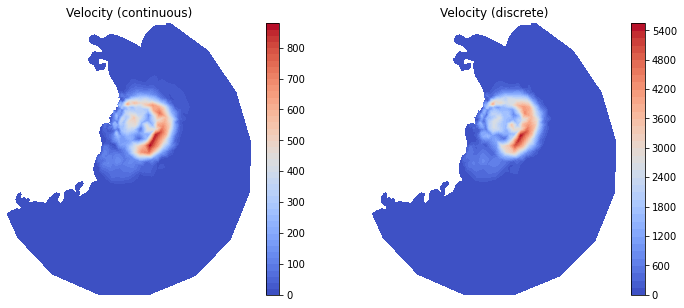

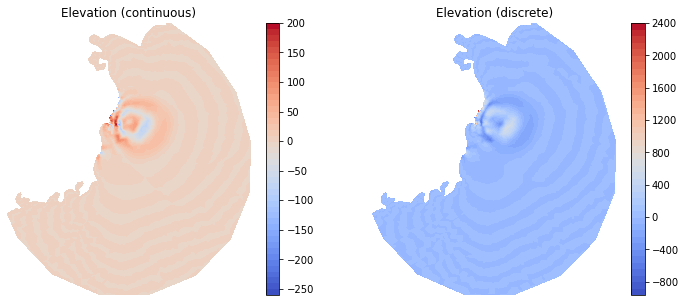

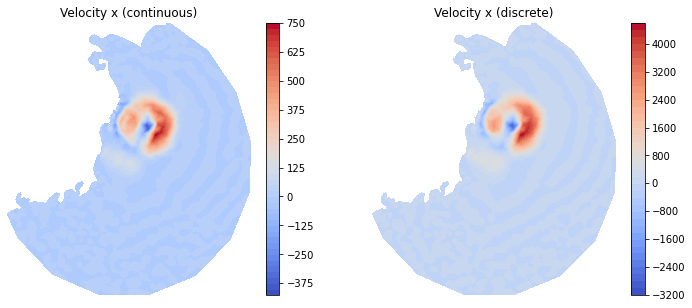

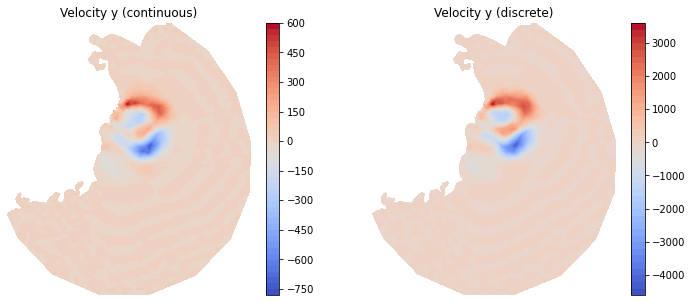

In [25]:
u_star_cts, eta_star_cts = q_star.split()
u_star_dis, eta_star_dis = solve_blocks[0].adj_sol.split()
u_star_cts.dat.name = "Velocity (continuous)"
eta_star_cts.dat.name = "Elevation (continuous)"
u_star_dis.dat.name = "Velocity (discrete)"
eta_star_dis.dat.name = "Elevation (discrete)"
plot_fields(u_star_cts, u_star_dis);
plot_fields(eta_star_cts, eta_star_dis);
for i, comp in enumerate(('Velocity x', 'Velocity y')):
    u_star_cts_comp = Function(P1, name=comp + " (continuous)")
    u_star_dis_comp = Function(P1, name=comp + " (discrete)")
    u_star_cts_comp.interpolate(u_star_cts[i])
    u_star_dis_comp.interpolate(u_star_dis[i])
    plot_fields(u_star_cts_comp, u_star_dis_comp)

The discrete and continuous adjoint solutions look pretty comparable in the eyeball norm except for two important points:
* The elevation has the opposite sign!
* Both elevation and velocity profiles have the different magnitudes.

# [FIXME]

### Tangent linear model

For each control parameter $m_k$, the tangent linear model for the sensitivities

$$
    \mathbf u_k := \frac{\partial\mathbf u}{\partial m_k},\qquad
    \eta_k := \frac{\partial\eta}{\partial m_k}
$$

can easily be derived by hand as

$$
    \frac{\partial\mathbf u_k}{\partial t}+g\nabla\eta_k+f\widehat{\mathbf z}\times\mathbf u_k=\boldsymbol0,\qquad
    \frac{\partial\eta_k}{\partial t}+\nabla\cdot(b\mathbf u_k)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with initial and boundary conditions

$$
    \mathbf u_k\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta_k|_{\Gamma_{100}}\equiv0,\qquad
    \mathbf u_k|_{t=0}\equiv\boldsymbol0,\qquad
    \eta_k|_{t=0}=g_k.
$$

### Gradient derivation

We seek the gradient of the QoI w.r.t. the control parameters.
We have

$$
    \frac{\mathrm dJ}{\mathrm dm_k}=\sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb 1_g(\eta-\eta_g)\frac{\partial\eta}{\partial m_k}\;\mathrm dx\;\mathrm dt,
$$

which involves the sensitivities of the free surface w.r.t. the controls.
Adding in zero and substituting the adjoint equation yields

$$
    \frac{\mathrm dJ}{\mathrm dm_k}=\int_0^T\int_\Omega
    \left(-\frac{\partial\mathbf u^*}{\partial t}-b\nabla\eta^*-f\widehat{\mathbf z}\times\mathbf u^*\right)\cdot\mathbf u_k
    +\left(-\frac{\partial\eta^*}{\partial t}-g\nabla\cdot\mathbf u^*\right)\eta_k
    \;\mathrm dx\;\mathrm dt.
$$

Integrating by parts gives

$$
    \frac{\mathrm dJ}{\mathrm dm_k}=
        \int_0^T\int_\Omega\left(
            -\frac{\partial}{\partial t}(\eta_k\eta^*)
            -\frac{\partial}{\partial t}(\mathbf u_k\cdot\mathbf u^*)
            +\left(
                \frac{\partial\eta_k}{\partial t}
                +\nabla\cdot(b\mathbf u_k)
            \right)\eta^*
            +\left(
                \frac{\partial\mathbf u_k}{\partial t}
                +g\nabla\eta_k
                +f\widehat{\mathbf z}\times\mathbf u_k
            \right)\cdot\mathbf u^*
        \right)\;\mathrm dx\;\mathrm dt\\
        -\int_0^T\int_{\partial\Omega}
            g\eta_k\mathbf u^*\cdot\widehat{\mathbf n}
            +b\eta^*\mathbf u_k\cdot\widehat{\mathbf n}
        \;\mathrm dx\;\mathrm dt.
$$

A lot of these terms cancel!
Applying the Fundamental Theorem of Calculus, the sensitivity equation and various initial and boundary conditions, we obtain

$$
    \frac{\mathrm dJ}{\mathrm dm_k} = \int_\Omega g_k\eta^*|_{t=0}\;\mathrm dx.
$$

That is, the gradient of the QoI w.r.t. the $k^{th}$ control is given by integrating the product of the $k^{th}$ basis function by the adjoint solution at the initial time.
We can compute the gradient __with respect to all parameters__ by solving the forward and adjoint equations once each and then integrating appropriate scalings of the adjoint solution at the initial time.

In [26]:
g_by_hand_discrete = assemble(phi*solve_blocks[0].adj_sol.split()[1]*dx)
print("Gradient computed by hand (discrete): {:.4e}".format(g_by_hand_discrete))
print("Relative error in gradient calculation: {:.4f}%".format(100*abs((g_discrete.dat.data[0] - g_by_hand_discrete)/g_discrete.dat.data[0])))

Gradient computed by hand (discrete): 1.4800e+12
Relative error in gradient calculation: 0.0000%


The error is zero because the discrete adjoint method allows the construction of gradients which are the true gradients of the _discrete functional_, which in some sense approximate gradients of the continuous functional.

Gradients computed using the continuous adjoint method, on the other hand, aren't true gradients of any functional at all. We just hope that they approximate the gradient of the discrete functional.

In [27]:
g_by_hand_continuous = assemble(phi*q_star.split()[1]*dx)
print("Gradient computed by hand (continuous): {:.4e}".format(g_by_hand_continuous))
print("Relative error in gradient calculation: {:.4f}%".format(100*abs((g_discrete.dat.data[0] - g_by_hand_continuous)/g_discrete.dat.data[0])))

Gradient computed by hand (continuous): -2.3297e+11
Relative error in gradient calculation: 115.7418%


We shouldn't expect agreement because the continuous adjoint solution doesn't look like the discrete adjoint

# [FIXME]

In order to use an optimisation routine based on Newton's method, we need both the gradient and also the Hessian.
To derive the Hessian by hand we'll need the second order tangent linear model.

During the forward solve, pyadjoint annotated to the tape, meaning we can compute the gradient using its inbuilt automatic differentiation functionality.

In [28]:
H_discrete = compute_hessian(J, Control(m), g_discrete)
print("Hessian computed using discrete adjoint: {:.4e}".format(*H_discrete.dat.data))

Hessian computed using discrete adjoint: 3.8389e+23


### Second order tangent linear model

For each control parameter $m_k$, the tangent linear model for the second order sensitivities

$$
    \mathbf u_{kk} := \frac{\partial^2\mathbf u}{\partial m_k^2},\qquad
    \eta_{kk} := \frac{\partial^2\eta}{\partial m_k^2}
$$

can easily be derived by hand as

$$
    \frac{\partial\mathbf u_{kk}}{\partial t}+g\nabla\eta_{kk}+f\widehat{\mathbf z}\times\mathbf u_{kk}=\boldsymbol0,\qquad
    \frac{\partial\eta_{kk}}{\partial t}+\nabla\cdot(b\mathbf u_{kk})=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with initial and boundary conditions

$$
    \mathbf u_{kk}\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta_{kk}|_{\Gamma_{100}}\equiv0,\qquad
    \mathbf u_{kk}|_{t=0}\equiv\boldsymbol0,\qquad
    \eta_{kk}|_{t=0}=0.
$$

### Hessian derivation

We seek the Hessian of the QoI w.r.t. the control parameters.
We have

$$
    \frac{\mathrm d^2J}{\mathrm dm_k^2}=\sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb 1_g\left[\left(\frac{\partial\eta}{\partial m_k}\right)^2+(\eta-\eta_g)\frac{\partial^2\eta}{\partial m_k^2}\right]\;\mathrm dx\;\mathrm dt,
$$

which involves the sensitivities of the free surface w.r.t. the controls.
Adding in zero and substituting the adjoint equation yields

$$
    \frac{\mathrm d^2J}{\mathrm dm_k^2}=
    \sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb 1_g\eta_k^2\;\mathrm dx\;\mathrm dt
    +\int_0^T\int_\Omega
    \left(-\frac{\partial\mathbf u^*}{\partial t}-b\nabla\eta^*-f\widehat{\mathbf z}\times\mathbf u^*\right)\cdot\mathbf u_{kk}
    +\left(-\frac{\partial\eta^*}{\partial t}-g\nabla\cdot\mathbf u^*\right)\eta_{kk}
    \;\mathrm dx\;\mathrm dt.
$$

Integrating by parts gives

$$
    \frac{\mathrm d^2J}{\mathrm dm_k^2}=
    \sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb 1_g\eta_k^2\;\mathrm dx\;\mathrm dt\\
        +\int_0^T\int_\Omega\left(
            -\frac{\partial}{\partial t}(\eta_{kk}\eta^*)
            -\frac{\partial}{\partial t}(\mathbf u_{kk}\cdot\mathbf u^*)
            +\left(
                \frac{\partial\eta_{kk}}{\partial t}
                +\nabla\cdot(b\mathbf u_{kk})
            \right)\eta^*
            +\left(
                \frac{\partial\mathbf u_{kk}}{\partial t}
                +g\nabla\eta_{kk}
                +f\widehat{\mathbf z}\times\mathbf u_{kk}
            \right)\cdot\mathbf u^*
        \right)\;\mathrm dx\;\mathrm dt\\
        -\int_0^T\int_{\partial\Omega}
            g\eta_{kk}\mathbf u^*\cdot\widehat{\mathbf n}
            +b\eta^*\mathbf u_{kk}\cdot\widehat{\mathbf n}
        \;\mathrm dx\;\mathrm dt.
$$

Almost all of the terms cancel!
Applying the Fundamental Theorem of Calculus, the sensitivity equation and various initial and boundary conditions, we are left with

$$
    \frac{\mathrm d^2J}{\mathrm dm_k^2}=
    \sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb 1_g\eta_k^2\;\mathrm dx\;\mathrm dt.
$$

That is, the Hessian of the QoI w.r.t. the $k^{th}$ control is given by integrating the square of the first order sensitivities over the gauge indicator regions.
We can compute the Hessian __with respect to each parameter__ by solving the associated first order sensitivity equation.

Whilst we are able to compute the gradient w.r.t. an arbitrary number of parameters by just solving the forward and adjoint equations once each, computing the Hessian requires the solution of the sensitivity equation associated with each control.
For a basis with a reasonable dimension, this may well become infeasible quickly.
As such, it is probably best to just use a quasi-Newton method which uses an approximation to the Hessian.
If we provide functions to solve the forward problem and compute the gradient then we can just pass to `scipy.optimize.minimize`.